# Network Science
## Project: Social Network Analysis (VK)

* Student: Majid Sohrabi
* Program: Data Science



## Imports

In [1]:
import requests
import random
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
import math
%matplotlib inline
import scipy.io
import scipy.stats
import seaborn as sns
import scipy.spatial as spt
from IPython.display import SVG
import pandas as pd
import matplotlib.image as mpimg
from typing import Dict, List
from networkx.algorithms import community
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from scipy.stats import kstest
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import reverse_cuthill_mckee

## Read the (.gexf) file

In [2]:
G = nx.read_gexf('vk-friends-MS.gexf').to_undirected()

In [3]:
def delete_unnecessary_attrs(graph, *attrs):
    for node in graph.nodes:
        d_copy = list(graph.nodes[node])
        for key in d_copy:
            if key in attrs:
                del(graph.nodes[node][key])
    return graph

delete_unnecessary_attrs(G, 'nickname', 'photo_50', 'screen_name')

In [4]:
def select_gygantic_component(g: nx.Graph) -> nx.Graph:
    node_list = sorted(nx.connected_components(g), key = len, reverse=True)
    gg = node_list[0]
    len(node_list)
    for i in range(len(node_list) - 1):
        g.remove_nodes_from(node_list[i+1])
    return g

gig_component = G.copy()
gig_component = select_gygantic_component(gig_component)

## Structural Analysis

Tasks:

1.   The closest random graph model similar to your social network (compare at least three models from lectures, such as ER, BA, WS). Check three real-world network properties on chosen random graph models and your ego-network, compare the results.
2.   Degree/Closeness/Betweenness centralities (optional: Katz, Bonacich). 
3.   Top nodes interpretation (not just surnames, but how are they related to you).
4.   Page-Rank. HITS. Correlation comparison of centralities and prestige. Comparison of top nodes.
5.   Assortative Mixing according to node attributes (usually sex, city, educational status).
6.   Node structural equivalence/similarity (interpret how they are similar from communicative patterns).


1.   The closest random graph model similar to your social network (compare at least three models from lectures, such as ER, BA, WS). Check three real-world network properties on chosen random graph models and your ego-network, compare the results.

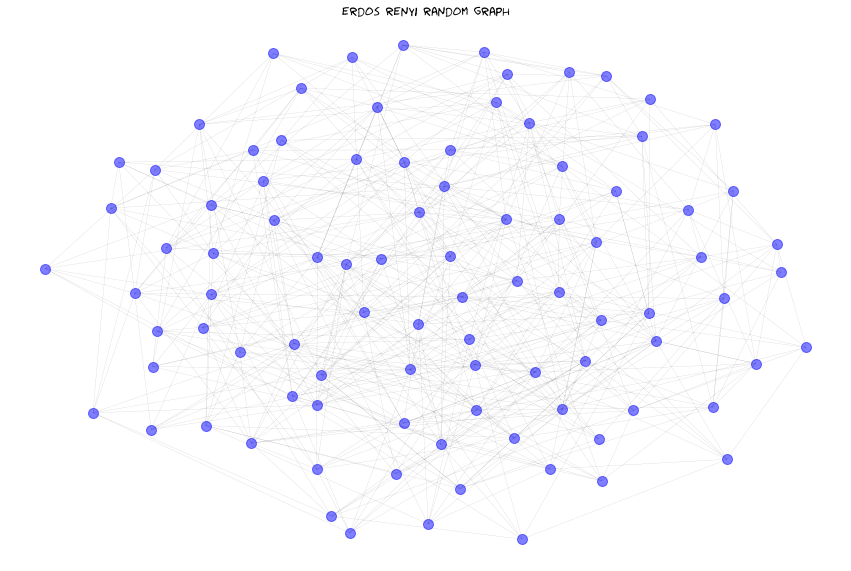

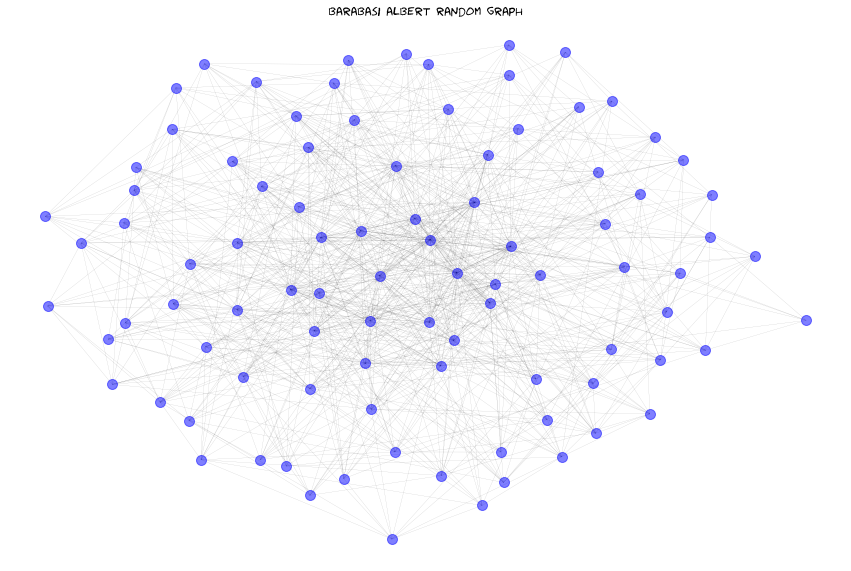

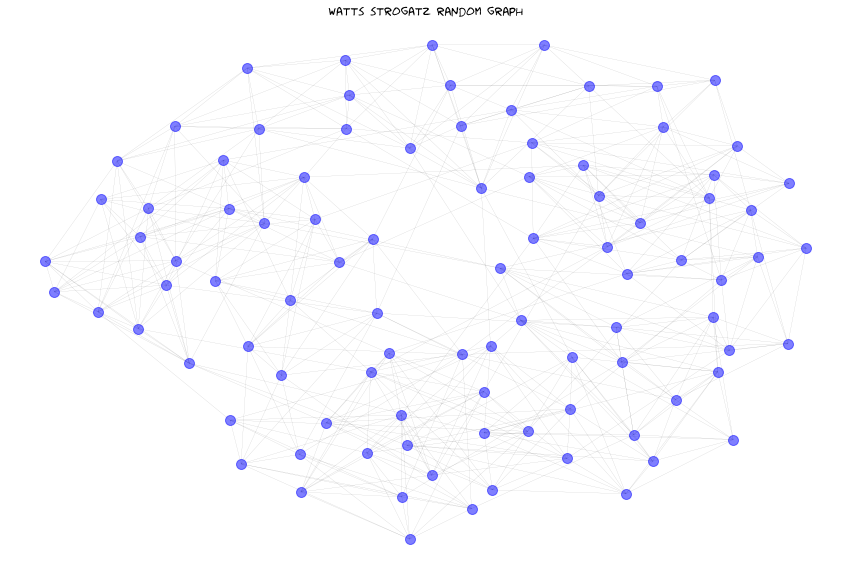

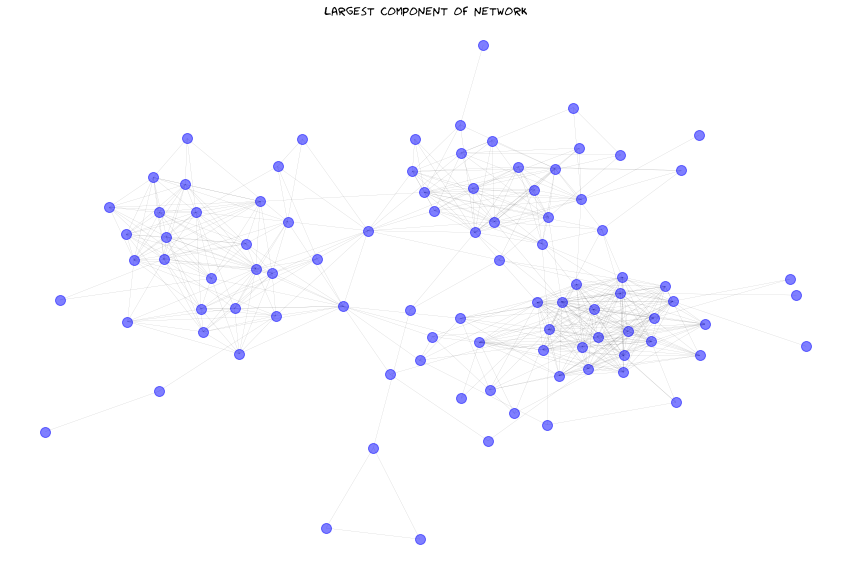

In [5]:
n_nodes = len(gig_component.nodes())
avg_edges = np.array([d for n, d in gig_component.degree()]).mean()
prob = avg_edges/n_nodes

# Erdos Reny
er_g = nx.fast_gnp_random_graph(n_nodes, prob, seed=1)

# Barbasi Albert
ba_g = nx.barabasi_albert_graph(n_nodes, int(avg_edges), seed=1)

# Watts-Strogatz
ws_g = nx.watts_strogatz_graph(n_nodes, int(avg_edges), p=0.1, seed=1)

rgs = {'erdos renyi random graph': er_g,
       'barabasi albert random graph':ba_g,
       'watts strogatz random graph':ws_g,
       'largest component of network': gig_component}

def customized_color(name_cmap, alpha):
  cmap = plt.get_cmap(name_cmap)
  custom_cmap = cmap(np.arange(cmap.N))
  custom_cmap[:,-1] = np.linspace(alpha, 1, cmap.N)
  custom_cmap = ListedColormap(custom_cmap)
  return custom_cmap

def pos_layout(g):
  df = pd.DataFrame(index=g.nodes(), columns=g.nodes())
  for row, data in nx.shortest_path_length(g):
      for col, dist in data.items():
          df.loc[row,col] = dist

  df = df.fillna(df.max().max())
  return df

for rg_title, rg in rgs.items():
    df = pos_layout(rg)
    pos = nx.kamada_kawai_layout(rg, dist=df.to_dict())
    plt.figure(figsize=(15, 10))
    plt.title(rg_title)
    nx.draw(rg, 
            pos=pos,
            width=0.1,
            node_color='blue',
            node_size=100,
            alpha=0.5)
    plt.show()

In [6]:
def graph_properties(g):
  diameter = nx.diameter(g)
  radius = nx.radius(g)
  avg_path = nx.average_shortest_path_length(g)
  clustering = nx.average_clustering(g)
  return {'diameter': diameter,
          'radius': radius,
          'avg shortest path': avg_path,
          'avg clustering': clustering}

def get_gk(expected, actual, sigma): 
  return {k: (math.exp(-(expected[k]-actual[k])**2/(2*sigma[k]**2))) for k in actual}

In [7]:
sigma = {'diameter': 3,
          'radius': 1,
          'avg shortest path': 1,
          'avg clustering': 0.001}

gig_component_prop = graph_properties(rgs['largest component of network'])
gk_dict = {}
rg_prop_dict = {}

for rg_title, rg in rgs.items():
  rg_prop = graph_properties(rg)
  gk = get_gk(gig_component_prop, rg_prop, sigma)
  rg_prop_dict[rg_title] = rg_prop 
  gk_dict[rg_title] = gk

df1 = pd.DataFrame().from_dict(rg_prop_dict)
df1['sigma'] = pd.Series(sigma)

df2 = pd.DataFrame().from_dict(gk_dict)
df2 = df2.transpose()
df2['Total Score'] = df2.sum(axis=1)/4
display(df1.transpose())
print('')
display(df2)

,diameter,radius,avg shortest path,avg clustering
erdos renyi random graph,3.0,3.0,2.129967,0.113438
barabasi albert random graph,3.0,2.0,1.845956,0.312596
watts strogatz random graph,4.0,3.0,2.564984,0.484400
largest component of network,7.0,4.0,2.904628,0.557361
sigma,3.0,1.0,1.000000,0.001000


,diameter,radius,avg shortest path,avg clustering,Total Score
erdos renyi random graph,0.411112,0.606531,0.740781,0.0,0.439606
barabasi albert random graph,0.411112,0.135335,0.570984,0.0,0.279358
watts strogatz random graph,0.606531,0.606531,0.943953,0.0,0.539253
largest component of network,1.000000,1.000000,1.000000,1.0,1.000000


2.   Degree/Closeness/Betweenness centralities (optional: Katz, Bonacich).
3.   Top nodes interpretation (not just surnames, but how are they related to you).

In [8]:
def centralities(G: nx.Graph):
    central = {}
    central['degree'] = np.array(list(nx.degree_centrality(G).values()))
    central['closeness'] = np.array(list(nx.closeness_centrality(G).values()))
    central['betweenness'] = np.array(list(nx.betweenness_centrality(G).values()))
    return central

def top10_centralities(G: nx.Graph):
    top10_centralities_dict = {}
    for i, j in zip(['degree', 'closeness', 'betweenness'], [nx.degree_centrality, nx.closeness_centrality, nx.betweenness_centrality]):            
        top10_deg_cent = sorted(j(G).items(), key=lambda x: x[1], reverse=True)[:10]
        ids, centrality = zip(*top10_deg_cent)
        sex = [G.nodes[id]['sex'] for id in ids]
        names = [G.nodes[id]['label'] for id in ids]
        top10_centralities_dict[i] = pd.DataFrame({'id': ids,'name':names , 'sex':sex, 'centrality': centrality})
    return top10_centralities_dict

c = centralities(G)
top_dfs = top10_centralities(G)
top_dfs

{'betweenness':           id                  name  sex  centrality
 0  169716343   Владимир Спиранских    2    0.063040
 1  337892544     Наталья Романчева    1    0.048627
 2  176213099       Мария Ястребова    1    0.037173
 3  222783240          Оля Магунова    1    0.027016
 4  112793838           Лина Махова    1    0.025188
 5  289269459  Маргарита Резниченко    1    0.023602
 6  154649788   Анастасия Николаева    1    0.019751
 7   58242096        Соня Ахманаева    1    0.018657
 8  145514474    Вероника Мезенцева    1    0.017737
 9   53045513     Соня Белопольская    1    0.016468,
 'closeness':           id                  name  sex  centrality
 0  176213099       Мария Ястребова    1    0.251456
 1  155211487        Мария Шурупова    1    0.242869
 2  169716343   Владимир Спиранских    2    0.241690
 3  337892544     Наталья Романчева    1    0.240523
 4  222783240          Оля Магунова    1    0.237087
 5  247082977       Марина Миронова    1    0.228386
 6  112793838    

In [9]:
top_dfs = top10_centralities(G)
top_name_center_dict = {}
for k,v in top_dfs.items():
  top_name_center = top_dfs[k][['name']][:3].set_index(top_dfs[k]['id'][:3]).to_dict()['name']
  top_name_center_dict[k]=top_name_center
top_name_center_dict

{'betweenness': {'169716343': 'Владимир Спиранских',
  '176213099': 'Мария Ястребова',
  '337892544': 'Наталья Романчева'},
 'closeness': {'155211487': 'Мария Шурупова',
  '169716343': 'Владимир Спиранских',
  '176213099': 'Мария Ястребова'},
 'degree': {'136717675': 'Слава Ежкова',
  '222783240': 'Оля Магунова',
  '53553851': 'Аня Князева'}}

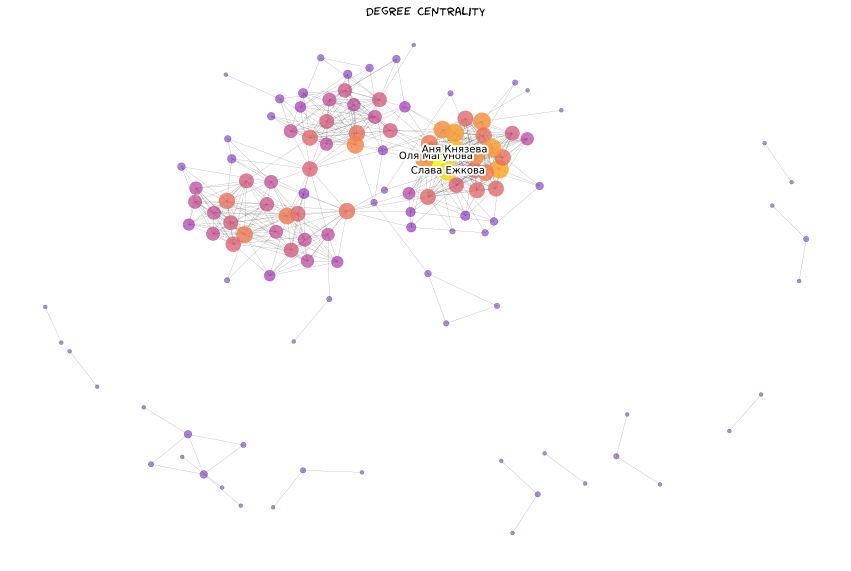

,id,name,sex,centrality
0,222783240,Оля Магунова,1,0.158824
1,136717675,Слава Ежкова,1,0.147059
2,53553851,Аня Князева,0,0.135294
3,50990055,Виктория Лобода,1,0.129412
4,112469438,Анастасия Каймакова,1,0.123529
5,168677202,Анастасия Каменская,1,0.123529
6,13563399,Оля Стальгорова,1,0.117647
7,85683456,Аня Каширина,1,0.117647
8,247082977,Марина Миронова,1,0.117647
9,290104751,София Ксенофонтова,2,0.117647


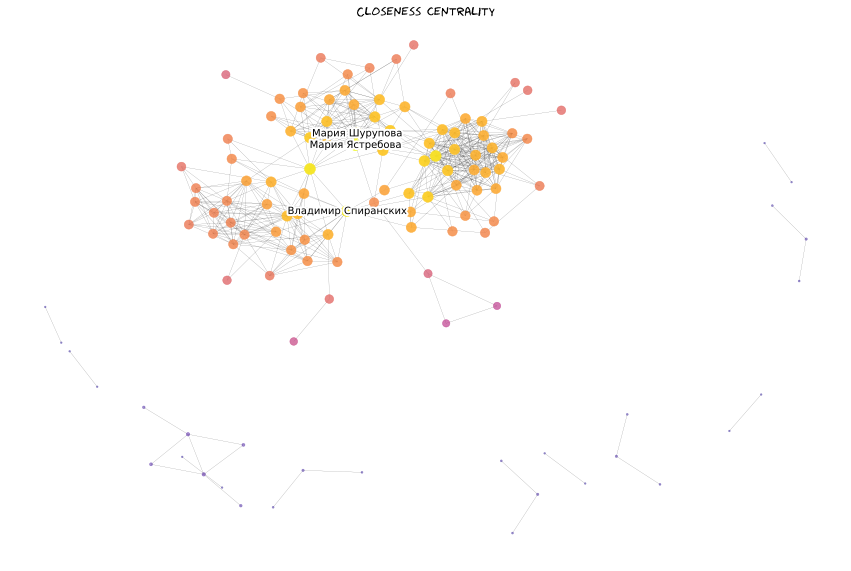

,id,name,sex,centrality
0,176213099,Мария Ястребова,1,0.251456
1,155211487,Мария Шурупова,1,0.242869
2,169716343,Владимир Спиранских,2,0.241690
3,337892544,Наталья Романчева,1,0.240523
4,222783240,Оля Магунова,1,0.237087
5,247082977,Марина Миронова,1,0.228386
6,112793838,Лина Махова,1,0.226310
7,289269459,Маргарита Резниченко,1,0.224271
8,140645785,Наталья Поротникова,1,0.223266
9,136717675,Слава Ежкова,1,0.221281


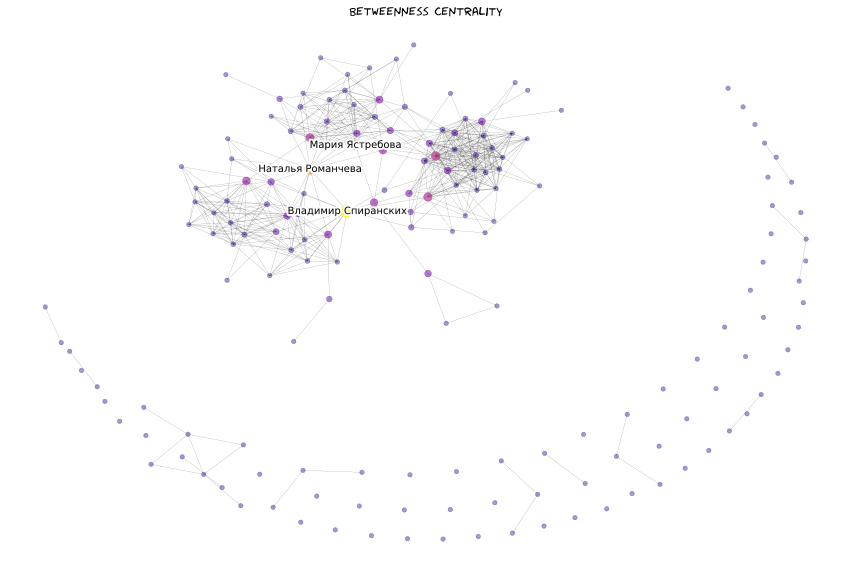

,id,name,sex,centrality
0,169716343,Владимир Спиранских,2,0.063040
1,337892544,Наталья Романчева,1,0.048627
2,176213099,Мария Ястребова,1,0.037173
3,222783240,Оля Магунова,1,0.027016
4,112793838,Лина Махова,1,0.025188
5,289269459,Маргарита Резниченко,1,0.023602
6,154649788,Анастасия Николаева,1,0.019751
7,58242096,Соня Ахманаева,1,0.018657
8,145514474,Вероника Мезенцева,1,0.017737
9,53045513,Соня Белопольская,1,0.016468


In [10]:
cases = [['degree', 2500, 0, 'Degree centrality'], 
         ['closeness', 500, 0, 'Closeness centrality'], 
         ['betweenness', 2000, 20, 'Betweenness centrality']]
my_cmap = customized_color('plasma', 0.4)
df = pos_layout(G)
pos = nx.kamada_kawai_layout(G, dist=df.to_dict())
for c_key, scale, bias, title in cases:
    label = top_name_center_dict[c_key]
    plt.figure(figsize=(15, 10))
    plt.title(title)
    nx.draw(G, 
            pos=pos,
            width=0.1,
            linewidths=0.5,
            cmap=my_cmap,
            node_size=c[c_key]*scale + bias,
            node_color=c[c_key])
    nx.draw_networkx_labels(G, pos=pos, labels=label, font_size=10)
    plt.show()
    display(top_dfs[c_key][:10])

*   Degree Centrality
    1. ```Оля Магунова``` is close friend of user.
    2. ```Слава Ежкова``` is close friend of user.
    3. ```Аня Князева``` is close friend of user.

*   Closeness Centrality
    1. ```Мария Ястребова``` is close friend of user.
    2. ```Мария Шурупова```	is close friend of user.
    3. ```Владимир Спиранских``` is close friend of user.

*   Betweenness Centrality
    1. ```Владимир Спиранских``` is close friend of user.
    2. ```Наталья Романчева``` is close friend of user.
    3. ```Мария Ястребова``` is close friend of user.

4.   Page-Rank. HITS. Correlation comparison of centralities and prestige. Comparison of top nodes.

,id,name,sex,centrality
0,222783240,Оля Магунова,1,0.015547
1,136717675,Слава Ежкова,1,0.014864
2,176213099,Мария Ястребова,1,0.014246
3,189082800,Оля Коваль,1,0.012664
4,349915855,Таня Даларнская,1,0.012664


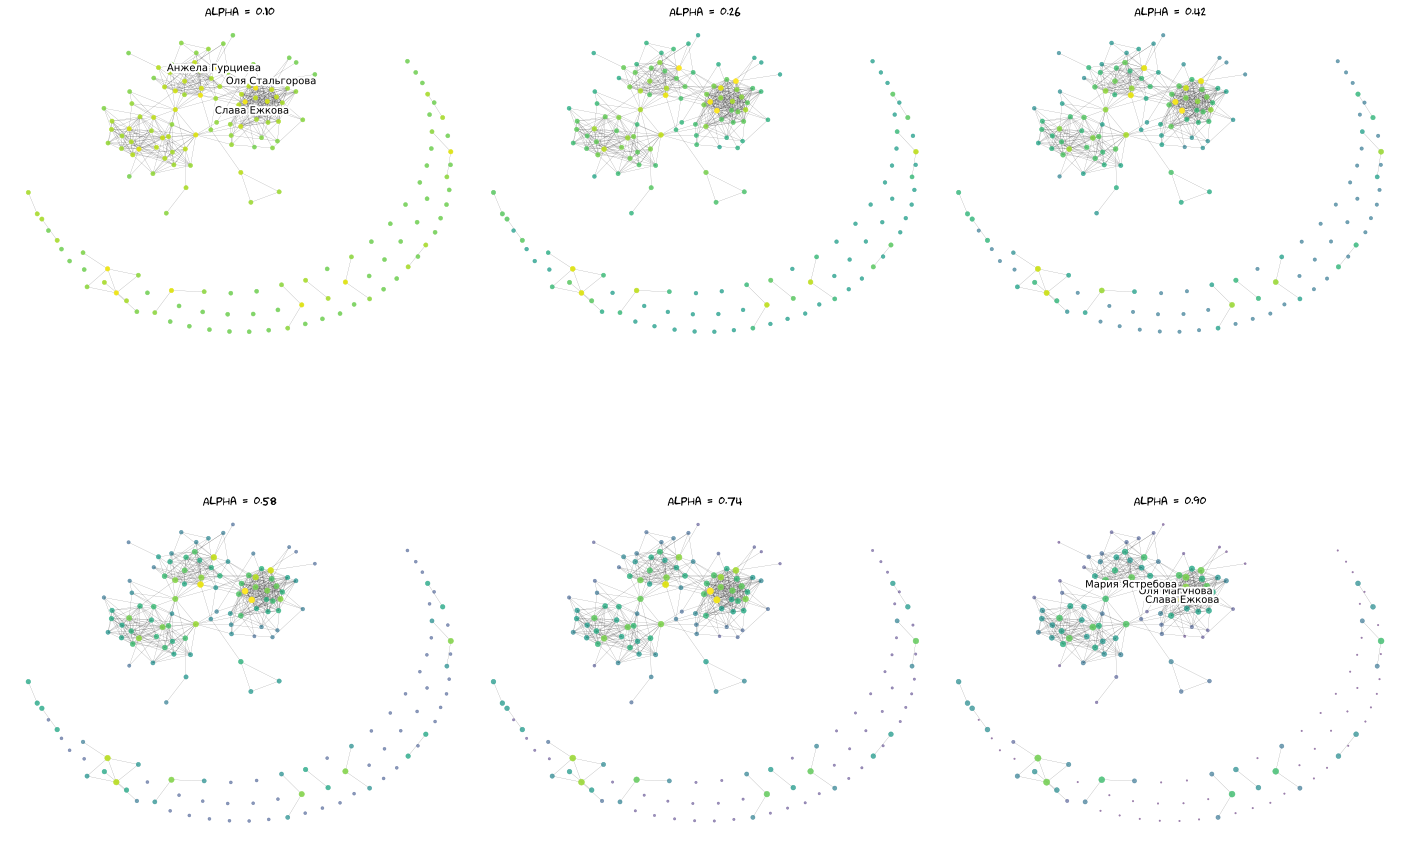

In [11]:
def top10_pagerank(G, alpha):
    top10_centralities_dict = {}      
    top10_deg_page = sorted(list(nx.pagerank(G, alpha).items()), key=lambda x:x[1], reverse=True)[:10]
    ids, centrality = zip(*top10_deg_page)
    sex = [G.nodes[id]['sex'] for id in ids]
    names = [G.nodes[id]['label'] for id in ids]
#         relation = [G.nodes[id]['relation'] for id in ids]
    top10_centralities_dict = pd.DataFrame({'id': ids,'name':names , 'sex':sex, 'centrality': centrality})
    return top10_centralities_dict



cmap = customized_color('viridis', 0.45)
PR_alphas = np.arange(0.1, 1, 0.16)

df = pos_layout(G)
pos = nx.kamada_kawai_layout(G, dist=df.to_dict())

fig, axes = plt.subplots(2,3, figsize=(25,15))
fig.subplots_adjust(hspace = .5, wspace=.001)
axe = axes.ravel()

for alpha, i in zip(PR_alphas,np.arange(0,6)):
    top_dfs_pr = top10_pagerank(G, alpha)
    top_name_pr = top_dfs_pr[['name']][:3].set_index(top_dfs_pr['id'][:3]).to_dict()['name']
    PR = nx.pagerank(G, alpha)
    node_size = [pr*3e3 for node, pr in PR.items()]
    norm = plt.Normalize(0, max(PR.values()))
    node_colors = [cmap(norm(PR[node])) for node in G.nodes]


    axe[i].set_title('Alpha = {:.2f}'.format(alpha))
    nx.draw(G, 
            pos=pos,
            width=0.1,
            linewidths=0.5,
            node_size=node_size,
            node_color=node_colors,
            ax=axe[i]
            ) 
    if i in [0,5]:
      nx.draw_networkx_labels(G, 
                              pos=pos, 
                              labels=top_name_pr, 
                              font_size=10,
                              ax=axe[i])

display(top10_pagerank(G, 0.85)[:5])

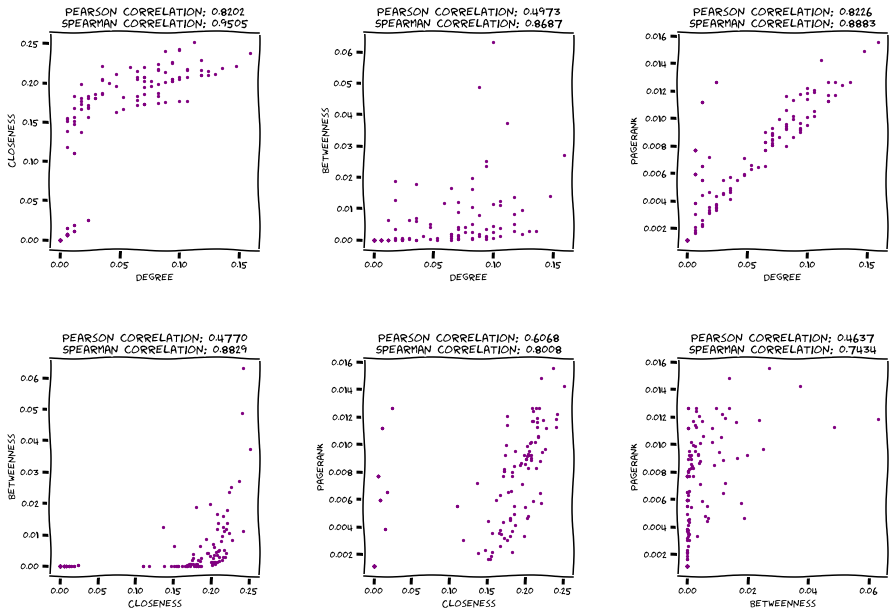

In [12]:
def pearson(a,b):
    return np.corrcoef(a, b)[0][1]
def spearman(a,b):
    return spearmanr(a, b)[0]

corrvals = [
    ('Degree', list(nx.degree_centrality(G).values())),
    ('Closeness', list(nx.closeness_centrality(G).values())),
    ('Betweenness', list(nx.betweenness_centrality(G).values())),
    ('PageRank', list(nx.pagerank(G).values()))
]

plt.figure(figsize=(3*5, 2*5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
k = 1
for i in range(len(corrvals)):
    for j in range(i + 1, len(corrvals)):
        i_label, i_vals = corrvals[i]
        j_label, j_vals = corrvals[j]
        pcorrelation = pearson(i_vals, j_vals)
        scorrelation = spearman(i_vals, j_vals)
        plt.subplot(2, 3, k)
        plt.scatter(i_vals, j_vals, s=5, color='purple')
        plt.title('Pearson correlation: {:.4f}\nSpearman correlation: {:.4f}'.format(pcorrelation, scorrelation))
        plt.xlabel(i_label)
        plt.ylabel(j_label)
        k += 1

5.   Assortative Mixing according to node attributes (usually sex, city, educational status).

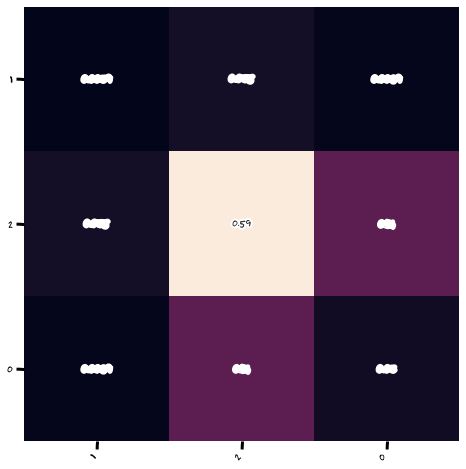

In [13]:
def genre_mixing(G):
  mixing = nx.attribute_mixing_matrix(G, 'sex')
  attr_val = nx.get_node_attributes(G, 'sex')
  mapping = {}

  index = 0
  for key in attr_val:
    if(attr_val[key] not in mapping):
      mapping[attr_val[key]] = index
      index += 1

  return mixing, mapping

mixing, mapping = genre_mixing(gig_component)

fig = plt.figure(figsize=(8, 8))

hmap = sns.heatmap(
    mixing,
    cbar=False,
    annot=True,
    square=True)
hmap.set_xticklabels(
    labels=[m for m in mapping], 
    rotation=45, 
    horizontalalignment='right')
hmap.set_yticklabels(
    labels=[m for m in mapping], 
    rotation=0)
plt.show()

6.   Node structural equivalence/similarity (interpret how they are similar from communicative patterns).

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


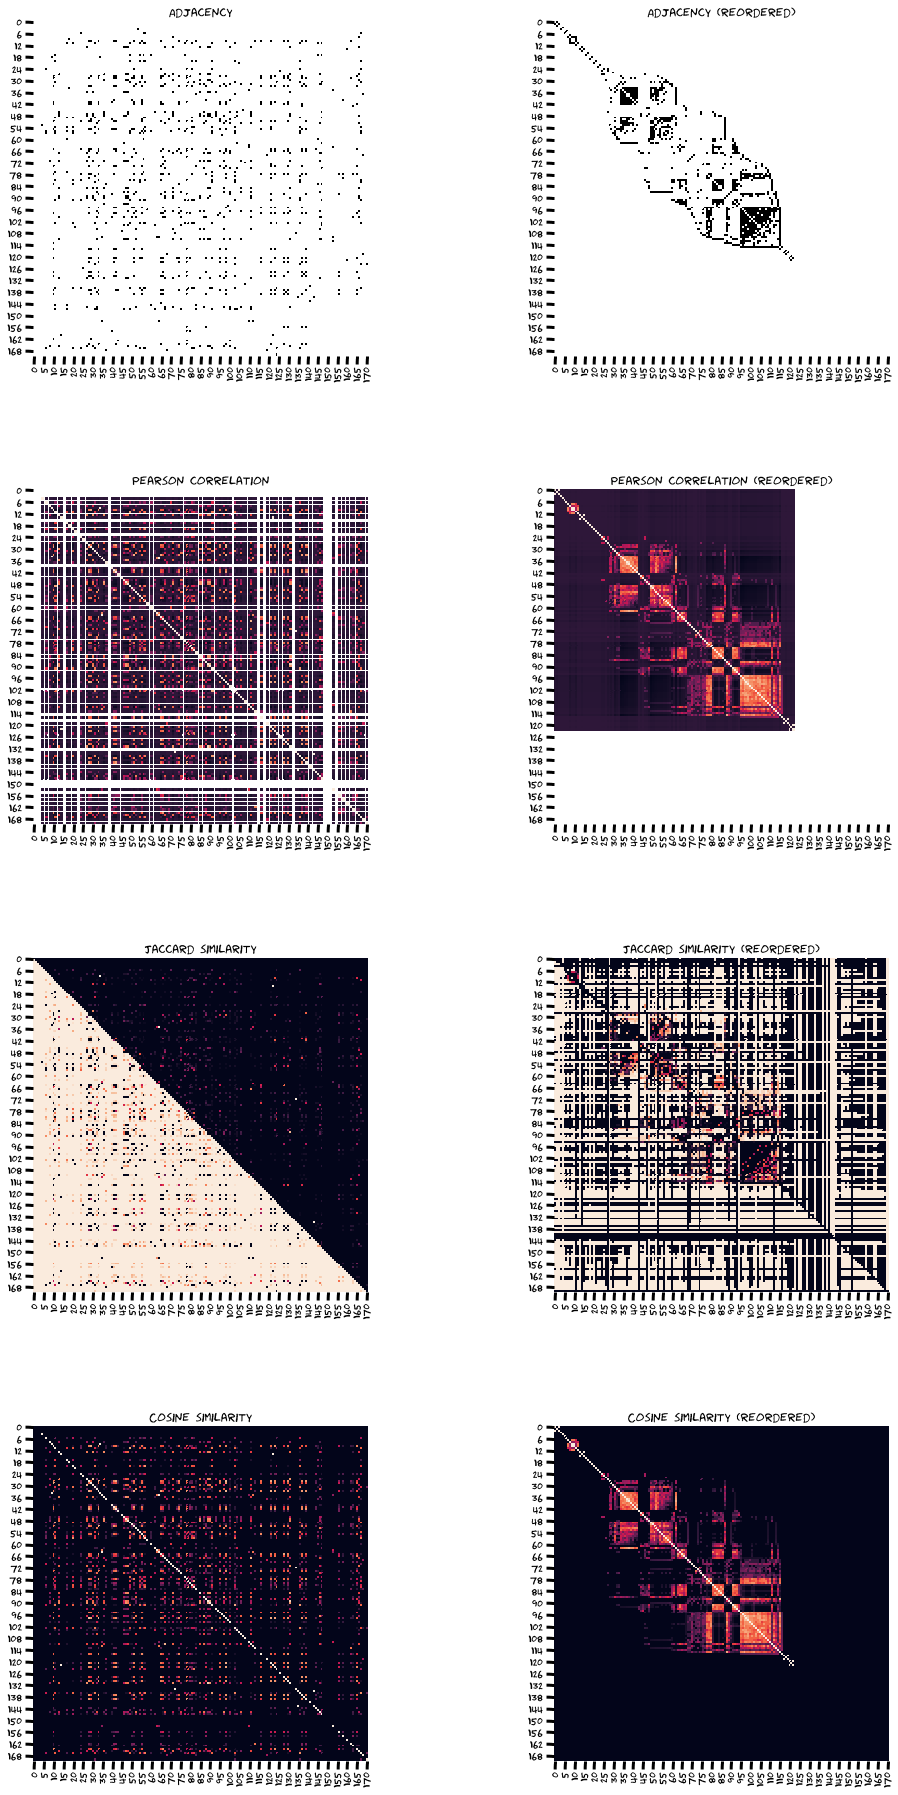

In [14]:
def sim_matrices(G):
  A = nx.to_numpy_array(G)
  pc = np.corrcoef(A)
  J = np.zeros(A.shape)
  for i, j, c in nx.jaccard_coefficient(nx.from_numpy_array(A)):
    J[i,j] = c 
    J[j,i] = 1-c 

  cs = cosine_similarity(A)
  
  return A, pc, J, cs

def cm_order(G):
  adj_matrix = nx.adjacency_matrix(G)

  return reverse_cuthill_mckee(adj_matrix)



A, corr, J, cos = sim_matrices(G)
order = cm_order(G)

fig = plt.figure(figsize=(16, 16*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

cases = [[1, A, plt.cm.Greys, 'Adjacency', range(len(nx.degree(G)))],
         [2, A, plt.cm.Greys, 'Adjacency (reordered)', order],
         [3, corr, None, 'Pearson correlation', range(len(nx.degree(G)))], 
         [4, corr, None, 'Pearson correlation (reordered)', order], 
         [5, J, None, 'Jaccard similarity', range(len(nx.degree(G)))], 
         [6, J, None, 'Jaccard similarity (reordered)', order], 
         [7, cos, None, 'Cosine similarity', range(len(nx.degree(G)))], 
         [8, cos, None, 'Cosine similarity (reordered)', order]]

for i, matrix, cmap, t, o in cases:
    plt.subplot(4, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True)
    plt.title(t)